# Twitter Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Juan Manuel Rodriguez, Salomey Osei, Gonzalo Uribarri

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Step 1: Questions and goals

* Can we infer emotion from a tweet text?
* How words are distributed accross the dataset?
* Are words related to one kind of emotion?

---
# Step 2: Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

---
# Step 3: Load and explore the dataset

##  Install dependencies


In [ ]:
# @title Install dependencies
# !pip install pandas --quiet
# !pip install torchtext --quiet

In [10]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

You can find the dataset we are going to use in [this website](http://help.sentiment140.com/for-students/).

In [13]:
import requests, zipfile, io
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [14]:
# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Let's have a look at it
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For this project we will use only the text and the polarity of the tweet. Notice that polarity is 0 for negative tweets and 4 for positive tweet.

The first thing we have to do before working on the models is to familiarize ourselves with the dataset. This is called Exploratory Data Analisys (EDA).

In [16]:
df1 = df.copy()

In [18]:
######################################################################################
#remove URLs
import re
pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
def rem_url(x):
  match = re.findall(pattern, x)
  for m in match:
    url = m[0]
    x = x.replace(url, '')
  return x

df1['url_removed'] = df1['text'].apply(lambda x:rem_url(x))
# df1.head()
print('URL removed')

######################################################################################
#remove twitter handles from text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['handle_removed'] = df1['url_removed'].apply(lambda x:tknzr.tokenize(x))
# df1.head()
print('Twitter Handles removed')
# detokenize the tweet again
from nltk.tokenize.treebank import TreebankWordDetokenizer
df1['orig'] = df1['handle_removed'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))
print('Tweets detokenized again')
# df1.head()
######################################################################################
# remove punctuations
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df1['clean_msg']= df1['orig'].apply(lambda x:remove_punctuation(x))
# df1.head()
print('Punctuation removed')
######################################################################################
# delete the unnecessary columns
del df1['url_removed']
del df1['handle_removed']
del df1['orig']
# df1.head()
######################################################################################
# remove the upper case letters
df1['msg_lower'] = df1['clean_msg'].apply(lambda x: x.lower())
# df1.head()
print('All set to lower case')
######################################################################################
# tokenize
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
#applying function to the column
# df1['msg_tokenied']= df1['msg_lower'].apply(lambda x: tokenization(x))
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['msg_tokenied'] = df1['msg_lower'].apply(lambda x:tknzr.tokenize(x))
# df1.head()
print('Tweet tokenized again')
######################################################################################
# removing stop words
#importing nlp library
import nltk
nltk.download('stopwords')
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
# stopwords[0:10]

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
df1['no_stopwords']= df1['msg_tokenied'].apply(lambda x:remove_stopwords(x))
# df1.head()
print('Stopwords removed')
######################################################################################
#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
porter_stemmer = PorterStemmer()
#defining a function for stemming
def stemming(text):
  stem_text = [porter_stemmer.stem(word) for word in text]
  return stem_text

df1['msg_stemmed']=df1['no_stopwords'].apply(lambda x: stemming(x))
# df1.head()
print('Tweets stemmed')
######################################################################################
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
# nltk.download('wordnet')
#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

df1['msg_lemmatized']=df1['no_stopwords'].apply(lambda x:lemmatizer(x))
# df1.head()
print('Tweets Lemmatized')
######################################################################################

df2 = df1.copy()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df2.head()

,polarity,id,date,query,user,text,clean_msg,msg_lower,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awwwthats a bummer You shoulda got David Car...,awwwthats a bummer you shoulda got david car...,"[awwwthats, a, bummer, you, shoulda, got, davi...","[awwwthats, bummer, shoulda, got, david, carr,...","[awwwthat, bummer, shoulda, got, david, carr, ...","[awwwthats, bummer, shoulda, got, david, carr,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand...","[upset, cant, updat, facebook, text, itand, mi...","[upset, cant, update, facebook, texting, itand..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...","[dived, many, time, ball, managed, save, 50, r..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",noits not behaving at all im mad why am i he...,noits not behaving at all im mad why am i he...,"[noits, not, behaving, at, all, im, mad, why, ...","[noits, behaving, im, mad, herebecause, cant, ...","[noit, behav, im, mad, herebecaus, cant, see]","[noits, behaving, im, mad, herebecause, cant, ..."


In [20]:
# detokenize the tweet again
# from nltk.tokenize.treebank import TreebankWordDetokenizer
# df2['msg_lemmatized'] = df2['msg_lemmatized'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))
# df2['msg_stemmed'] = df2['msg_stemmed'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))
del df2['msg_lower']
del df2['text']
del df2['clean_msg']
df2.head()

,polarity,id,date,query,user,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[awwwthats, a, bummer, you, shoulda, got, davi...","[awwwthats, bummer, shoulda, got, david, carr,...","[awwwthat, bummer, shoulda, got, david, carr, ...","[awwwthats, bummer, shoulda, got, david, carr,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand...","[upset, cant, updat, facebook, text, itand, mi...","[upset, cant, update, facebook, texting, itand..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...","[dived, many, time, ball, managed, save, 50, r..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[noits, not, behaving, at, all, im, mad, why, ...","[noits, behaving, im, mad, herebecause, cant, ...","[noit, behav, im, mad, herebecaus, cant, see]","[noits, behaving, im, mad, herebecause, cant, ..."


In [5]:
# df2.to_csv('preprocessed_training_data.csv')


In [8]:
# If the data set is already loaded in the directory start from here.
df3 = pd.read_csv("../input/twitter-training-preprocessed/preprocessed_training_data.csv", index_col = 0)
df3.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,polarity,id,date,query,user,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"['awwwthats', 'a', 'bummer', 'you', 'shoulda',...","['awwwthats', 'bummer', 'shoulda', 'got', 'dav...",awwwthat bummer shoulda got david carr third day,awwwthats bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"['is', 'upset', 'that', 'he', 'cant', 'update'...","['upset', 'cant', 'update', 'facebook', 'texti...",upset cant updat facebook text itand might cri...,upset cant update facebook texting itand might...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"['i', 'dived', 'many', 'times', 'for', 'the', ...","['dived', 'many', 'times', 'ball', 'managed', ...",dive mani time ball manag save 50 rest go bound,dived many time ball managed save 50 rest go b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"['my', 'whole', 'body', 'feels', 'itchy', 'and...","['whole', 'body', 'feels', 'itchy', 'like', 'f...",whole bodi feel itchi like fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"['noits', 'not', 'behaving', 'at', 'all', 'im'...","['noits', 'behaving', 'im', 'mad', 'herebecaus...",noit behav im mad herebecaus cant see,noits behaving im mad herebecause cant see


In [22]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df2.msg_stemmed.values
# print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df2.polarity.values > 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# print out the sample data set
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

# # tokenize the text for furhter processing
# tokenizer = get_tokenizer("basic_english")

x_train_token = x_train_text #[tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = x_test_text #[tokenizer(s) for s in tqdm(x_test_text)]

# create a word counter
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

#sort the words
sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:10])

count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

# plt.bar(range(50), [words[w] for w in sorted_words[:50]])
# plt.show()

# #print the first 10 most common words
# for w in sorted_words[:10]:
#   print(w, words[w])

1: ['lol', 'get', 'idea', 'far', 'advanceit', 'even', 'june', 'yetw', 'need', 'third', 'knitter', 'summer', 'group']
0: ['worst', 'headach', 'ever']
0: ['sad', 'wont', 'see', 'youi', 'miss', 'alreadi', 'yeahthat', 'perfect', 'come', 'back', '18th']
1: ['doesnt', 'know', 'spell', 'conk']
0: ['stand', 'one', 'know', 'us', 'wont', 'get', 'use', 'wont', 'get', 'use', 'gone', 'miss', 'home', 'everyon']
Number of different Tokens in our Dataset: 610601
['im', 'go', 'get', 'day', 'good', 'like', 'work', 'love', 'dont', 'got']
The 0.6280697214711407% most common words account for the 80.00203885772501% of the occurrences


## Recurrent Neural Network with Pytorch

In [24]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

# Set the device (check if gpu is available)
device = set_device()

GPU is enabled in this notebook.


First we will create a Dictionary (`word_to_idx`). This dictionary will map each Token (usually words) to an index (an integer number). We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [ ]:
#Let us load the Glove embedded vectors
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip
# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip glove.twitter.27B.zip

In [26]:
# glove = pd.read_csv('glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
# glove_embedding = {key: val.values for key, val in glove.T.items()}

glove = pd.read_csv('../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}


In [28]:
#Let's select only the most used.
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]


#We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word
    
    
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))
 
  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
  return embedding_matrix


# My word_to_idx is the same as their word_index
embedding_matrix=create_embedding_matrix(word_to_idx,embedding_dict=glove_embedding,dimension=100)


#Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. 
# These sequences of indexes will be the input to our pytorch model.

# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)



# We need all the sequences to have the same length. 
# To select an adequate sequence length, let's explore some statistics about the length of the tweets:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  301
Mean tweet word length:  6.0
99% percent under:  17.0


In [41]:
# most_used_words[45]
# embedding_matrix[45,:]

'great'

In [42]:
# We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.
# We choose the max length
max_length = 20

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
 features = np.zeros((len(sentences), seq_len),dtype=int)
 for ii, tweet in enumerate(sentences):
   len_tweet = len(tweet) 
   if len_tweet != 0:
     if len_tweet <= seq_len:
       # If its shorter, we fill with zeros (the padding Token index)
       features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
     if len_tweet > seq_len:
       # If its larger, we take the last 'seq_len' indexes
       features[ii, :] = np.array(tweet)[-seq_len:]
 return features


# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)


# Now, let's convert the data to pytorch format.

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)


# Each batch of data in our traning proccess will have the folllowing format:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 20])
Sample input: 
 tensor([[    0,     0,     0,  ...,  1093,  1654,    59],
        [    0,     0,     0,  ..., 19590,  1805,  2796],
        [    0,     0,     0,  ...,    35,     6,  8346],
        ...,
        [    0,     0,     0,  ...,  1530,  1931,    33],
        [    0,     0,     0,  ...,   422,   299,   210],
        [    0,     0,     0,  ...,    89,    58,     5]])
Sample input: 
 tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.







SentimentRNN(
  (embedding): Embedding(30001, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  3075941
Epoch 1
train_loss : 0.47017578632803636 val_loss : 0.4562177909724414
train_accuracy : 77.602265625 val_accuracy : 78.5246875
Validation loss decreased (inf --> 0.456218).  Saving model ...
Epoch 2
train_loss : 0.44438347487477586 val_loss : 0.45523036549799145
train_accuracy : 79.168125 val_accuracy : 78.5303125
Validation loss decreased (0.456218 --> 0.455230).  Saving model ...


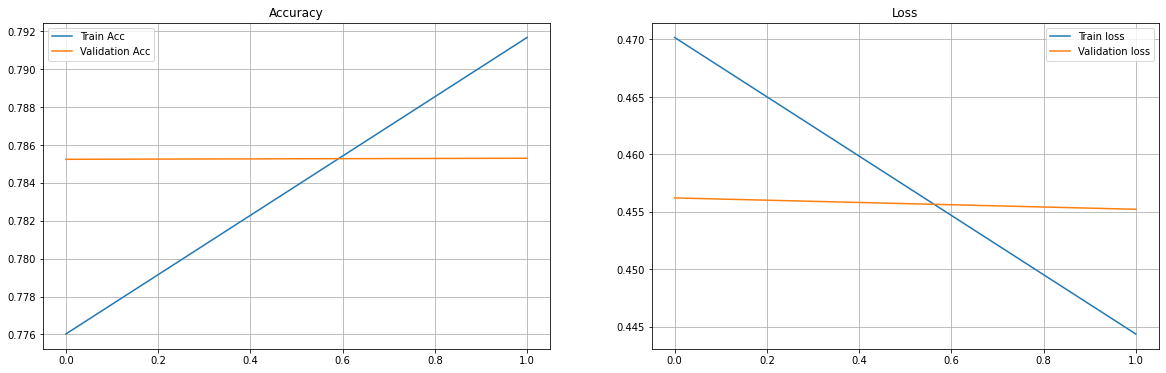

In [44]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob
    self.vocab_size=embedding_matrix.shape[0]
    self.embedding_dim=embedding_matrix.shape[1]
    
    # Let us set up the embedding layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=True

    # Embedding Layer
#     self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=False, batch_first=True, 
                        dropout=self.drop_prob)
#     print(self.lstm.shape)
    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]
    
    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]
    
    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    
    hidden = (h0,c0)
    return hidden

#######################################################################################
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
# embedding_dim = 00

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

# Let's define our model
model = SentimentRNN(no_layers, hidden_dim,embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

# loss and optimization functions
lr = 0.005

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()
#######################################################################################
#lets run the model for one epoch to test its ability to run.
# Number of training Epochs
epochs = 2

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
# plt.ylim([70, 80])
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

SentimentRNN(
  (embedding): Embedding(30001, 100)
  (gru): GRU(100, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  56897
Epoch 1
train_loss : 0.5025943557638675 val_loss : 0.4814420866686851
train_accuracy : 75.203046875 val_accuracy : 76.6778125
Validation loss decreased (inf --> 0.481442).  Saving model ...


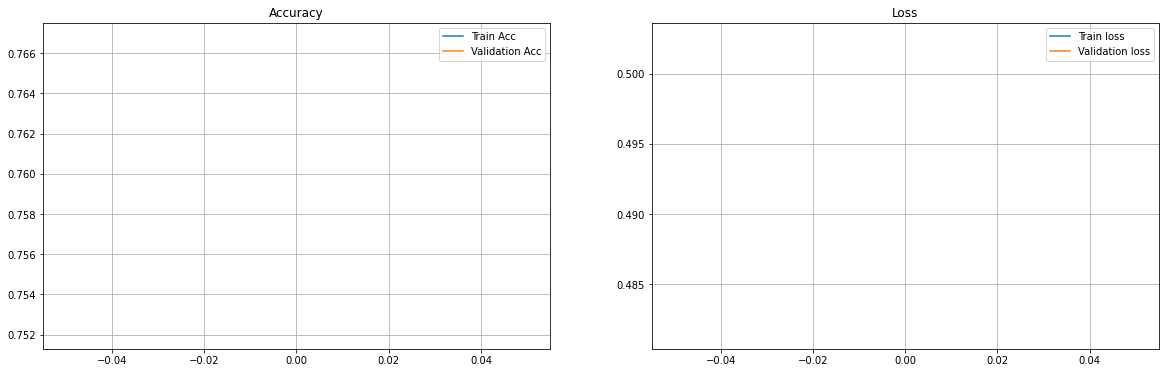

In [54]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob = 0.01):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob
    self.vocab_size=embedding_matrix.shape[0]
    self.embedding_dim=embedding_matrix.shape[1]
    
    # Let us set up the embedding layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=False

    # LSTM Layers
    self.gru = nn.GRU(input_size= self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=False, batch_first=True, 
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)
    self.h = self.init_hidden(batch_size)
    
    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # GRU out
    gru_out, self.h = self.gru(embeds, self.h)
    # lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    gru_out = gru_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(gru_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out #, hidden
  def init_hidden(self, batch_size):
    hidden = (torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device))
    return hidden

  # def init_hidden(self, batch_size):
  #   ''' Initializes hidden state '''
  #   # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
  #   # initialized to zero, for hidden state and cell state of LSTM
  #   h0 = torch.zeros((self.no_layers, batch_size,self.hidden_dim)).to(device)
  #   c0 = torch.zeros((self.no_layers, batch_size,self.hidden_dim)).to(device)
  #   hidden = (h0,c0)
  #   return hidden

#######################################################################################
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

# Let's define our model
model = SentimentRNN(no_layers, hidden_dim,
                     embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

# loss and optimization functions
lr = 0.001

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

# Number of training Epochs
epochs = 1

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Initialize hidden state 
    # h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    # h = tuple([each.data.to(device) for each in h])
    # print(h[1].shape)
    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state 
    # val_h = model.init_hidden(batch_size)
    # val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

---
# What's Next?

You can use this project template as a starting point to think about your own project. There are a lot of ways to continue, here we share with you some ideas you migth find useful:

*   **Work on the Preproccesing.** We used a very rudimentary way to tokenize tweets. But there are better ways to preprocess the data. Can you think of a suitable way to preprocess the data for this particular task? How does the performance of the model change when the data is processed correctly?
*   **Work on the Model.** The RNN model proposed in this notebook is not optimized at all. You can work on finding a better architecture or better hyperparamenters. May be using bidirectonal LSTMs or increasing the number of stacked layers can improve the performance, feel free to try different approaches.
*   **Work on the Embedding.** Our model learnt an embedding during the training on this Twitter corpus for a particular task. You can explore the representation of different words in this learned embedding. Also, you can try using different word embeddings. You can train them on this corpus or you can use an embedding trained on another corpus of data. How does the change of the embedding affect the model performance?
*   **Try sentiment analysis on another dataset.** There are lots of available dataset to work with, we can help you find one that is interesting to you. Do you belive that a sentiment analysis model trained on some corpus (Twitter dataset) will perform well on another type of data (for example, youtube comments)?

